In [1]:
import pandas as pd
import numpy as np
import zstandard as zstd
import os
import random
import xlsxwriter

import networkx as nx
from networkx.algorithms import community, bipartite
import igraph as ig

import powerlaw
import matplotlib.pyplot as plt
import seaborn
import scipy

## Load and prepare data

In [66]:
contracts = pd.read_csv('../data/raw/contracts.csv')
aggregated_country_year = pd.read_csv('../data/raw/aggregated_country_year.csv')

In [67]:
print(len(contracts))
print(len(aggregated_country_year))

4098711
234


In [68]:
contracts = contracts.drop(['Unnamed: 0'], axis=1)
contracts.head(3)

,tender_id,year,date_dispatched,issuer_id_final,issuer_name,issuer_canonical_name,issuer_country,issuer_address,issuer_postcode,issuer_town,...,contract_nuts,processed_nuts,contract_cpv,cpv2,contract_eu_funded,contract_type,procedure,n_bids,nocft,single_bidder
0,2.150556e+09,2008,2008-12-11,248_LV_i,"Rēzeknes pilsētas Izglītības pārvalde, LV90000...",rezeknes pilsetas izglitibas parvalde lv900000...,LV,Atbrīvošanas aleja 91,4600,Rēzekne,...,LV005,LV00,74200000.0,74,0.0,1. Services,open,4.0,0,0.0
1,2.152665e+09,2012,2012-12-20,295_UK_i,Chelsea & Westminster Hospital NHS Foundation ...,chelsea westminster hospital nhs foundation tr...,UK,369 Fulham Road,SW10 9NH,London,...,NaN,UK,33111800.0,33,0.0,2. Supplies,restricted,4.0,1,0.0
2,2.224763e+09,2008,2008-01-02,4555_PL_i,Zarząd Dróg i Zieleni w Gdańsku,zarzad drog i zieleni w gdansku_i,PL,ul. Partyzantów 36,80-254,Gdańsk,...,NaN,PL,45233141.0,45,0.0,3. Works,open,1.0,0,1.0


In [69]:
aggregated_country_year = aggregated_country_year.drop(['Unnamed: 0'], axis=1)
aggregated_country_year.head(3)

,country,year,ncontracts,sb_rate,nwinners,nissuers,nedges,non_core_sb_rate,core_ncontracts,core_sb_rate,...,core_density,core_to_non_sb,core_contract_share,eqi_score,ti_cpi,wbgi_cce,vdem_corr,sb_rate_08_16,sb_clustering_vs_random,sb_core_vs_random
0,AT,2008,3192,0.094337,1815,456,2324,0.121861,718,0.101374,...,0.011840,1.074591,0.224937,NaN,81.0,1.843035,0.139032,0.121968,2.088365,0.902565
1,AT,2009,3148,0.100352,1906,429,2482,0.074037,500,0.118953,...,0.012833,1.185354,0.158831,NaN,79.0,1.703025,0.139032,0.121968,3.600993,0.945130
2,AT,2010,3178,0.105601,1762,386,2339,0.149497,647,0.091780,...,0.011105,0.869121,0.203587,1.06285,79.0,1.585462,0.139032,0.121968,1.888154,0.796586


In [70]:
# Define a dictionary that maps each country to a color
country_colors_dict = {
    'AT': 'red',
    'BE': 'blue',
    'BG': 'green',
    'CY': 'purple',
    'CZ': 'orange',
    'DE': 'yellow',
    'DK': 'cyan',
    'EE': 'magenta',
    'ES': 'lime',
    'FI': 'teal',
    'FR': 'pink',
    'GR': 'brown',
    'HU': 'gray',
    'IE': 'navy',
    'IT': 'olive',
    'LT': 'maroon',
    'LV': 'gold',
    'NL': 'indigo',
    'NO': 'darkred',
    'PL': 'darkgreen',
    'PT': 'darkorange',
    'RO': 'darkcyan',
    'SE': 'darkmagenta',
    'SI': 'seagreen',
    'SK': 'sienna',
    'UK': 'slateblue'
}

aggregated_country_year['issuer_country'] = aggregated_country_year['country']
aggregated_country_year['winner_country'] = aggregated_country_year['country']

aggregated_country_year['issuer_color'] = aggregated_country_year['issuer_country'].map(country_colors_dict)
aggregated_country_year['winner_color'] = aggregated_country_year['winner_country'].map(country_colors_dict)

In [71]:
# merge contracts and aggregated_country_year country and year
contracts_merged = contracts.merge(aggregated_country_year.drop(['winner_country', 'winner_color'], axis=1), how='left', left_on=['issuer_country', 'year'], right_on=['issuer_country', 'year'])

contracts_merged = contracts_merged.merge(aggregated_country_year[['winner_country', 'winner_color', 'year']], how='left', left_on=['winner_country', 'year'], right_on=['winner_country', 'year'])

In [72]:
contracts_merged['tender_id'].nunique()

4098711

In [73]:
# add dummy if single_bidder > 50% (above annual market single bidding rate per country)
contracts_merged['sbr_above_50'] = contracts_merged['single_bidder'].apply(lambda x: 1 if x > 0.5 else 0)

In [74]:
sum(contracts_merged['sbr_above_50']==1)/len(contracts_merged.index)

0.20131719460093672

In [75]:
len(contracts_merged.index)

4098711

In [76]:
contracts_merged['player'] = "issuer"
contracts_merged['player'] = "winner"

In [77]:
contracts_merged_DE = contracts_merged[contracts_merged['issuer_country']=="DE"]

In [78]:
# add weights - number of contracts the nodes are involved in
contracts_merged_DE.loc[:, 'count'] = contracts_merged_DE.groupby(['issuer_id_final', 'winner_id_final', 'year', 'issuer_country'])['issuer_id_final'].transform('size')
contracts_merged_DE.loc[:, 'count_awarded'] = contracts_merged_DE.groupby(['issuer_id_final', 'year', 'issuer_country'])['issuer_id_final'].transform('size')
contracts_merged_DE.loc[:, 'count_won'] = contracts_merged_DE.groupby(['winner_id_final', 'year', 'issuer_country'])['winner_id_final'].transform('size')

C:\Users\admin\AppData\Local\Temp\ipykernel_14872\2991823459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_merged_DE.loc[:, 'count'] = contracts_merged_DE.groupby(['issuer_id_final', 'winner_id_final', 'year', 'issuer_country'])['issuer_id_final'].transform('size')
C:\Users\admin\AppData\Local\Temp\ipykernel_14872\2991823459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contracts_merged_DE.loc[:, 'count_awarded'] = contracts_merged_DE.groupby(['issuer_id_final', 'year', 'issuer_country

## Exploratory analysis

### Degree distribution of issuer/winner - Power Law

k - degree; no. of awarded/won contracts (count_awarded, count_won)

p(k) - degree distribution

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


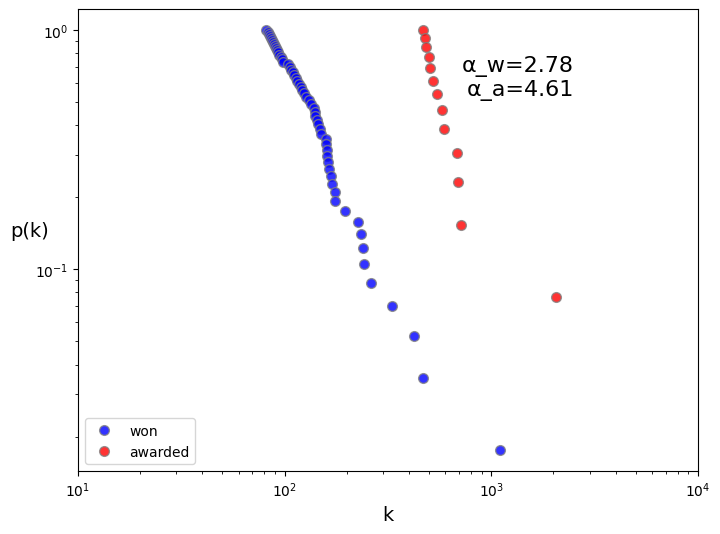

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

count_awarded_DE = contracts_merged_DE['count_awarded'].value_counts()
df_count_awarded_DE = pd.DataFrame({'count_awarded': count_awarded_DE.index, 'frequency_awarded': count_awarded_DE.values}).sort_values('count_awarded')

count_won_DE = contracts_merged_DE['count_won'].value_counts()
df_count_won_DE = pd.DataFrame({'count_won': count_won_DE.index, 'frequency_won': count_won_DE.values}).sort_values('count_won')

fit_won = powerlaw.Fit(df_count_won_DE['count_won'], discrete=True)
fit_awarded = powerlaw.Fit(df_count_awarded_DE['count_awarded'], discrete=True)

fit_won.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='blue', markeredgecolor='gray', alpha=0.8, label='won')
fit_awarded.plot_ccdf(ax=ax, color='gray', linestyle='', marker='.', markersize=14, markerfacecolor='red', markeredgecolor='gray', alpha=0.8, label='awarded')
ax.legend(loc='lower left')
ax.text(0.8, 0.9, f'α_w={fit_won.alpha:.2f}\nα_a={fit_awarded.alpha:.2f}', fontsize=16, transform=ax.transAxes, ha='right', va='top')

# set x-axis limits and ticks
x_min = 10
x_max = 10000
xticks = [10, 100, 1000, 10000]
ax.set_xlim(x_min, x_max)
ax.set_xticks(xticks)

# set axis labels
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('p(k)', fontsize=14, rotation=0)

# set plot title
# ax.set_title('Power Law Distribution of Awarded and Won Contracts', fontsize=16)

# plt.savefig('../output/figures/DE_power_law_dist' + '.png', bbox_inches='tight')
plt.show()


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


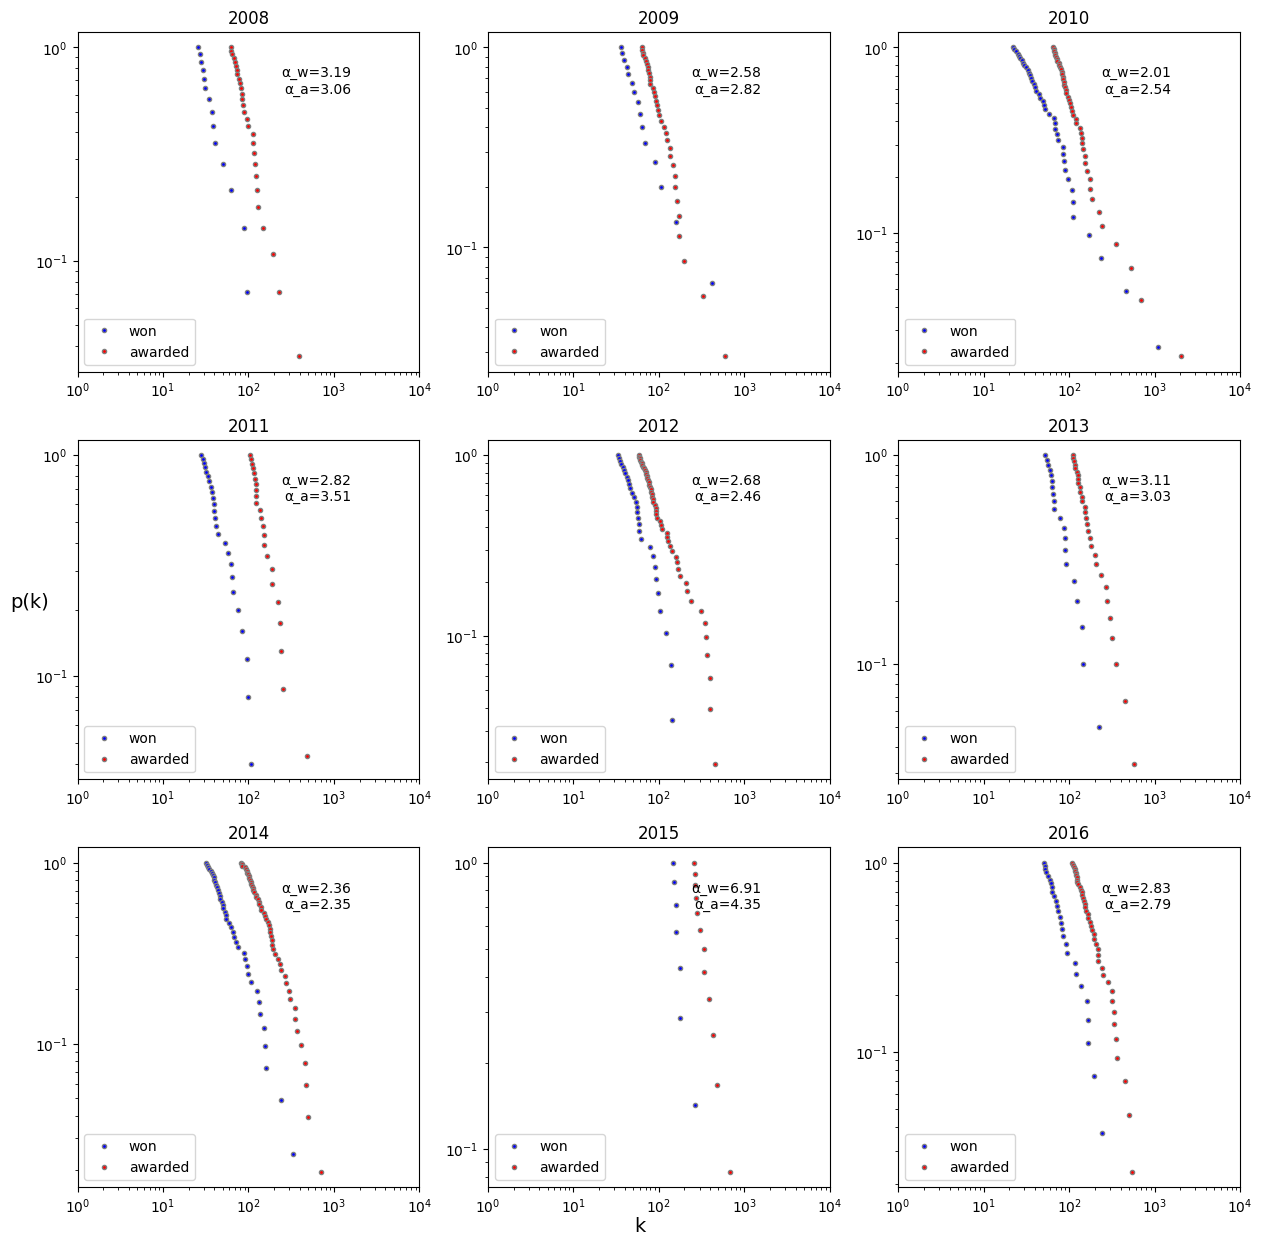

In [80]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

# set same x-axis limits and ticks for all subplots
x_min = 1
x_max = 10000
xticks = [1, 10, 100, 1000, 10000]

for i, year in enumerate(range(2008, 2017)):
    count_DE = contracts_merged_DE[contracts_merged_DE['year'] == year]['count'].value_counts()
    df_count_DE = pd.DataFrame({'count': count_DE.index, 'frequency': count_DE.values}).sort_values('count')

    count_awarded_DE = contracts_merged_DE[contracts_merged_DE['year'] == year]['count_awarded'].value_counts()
    df_count_awarded_DE = pd.DataFrame({'count_awarded': count_awarded_DE.index, 'frequency_awarded': count_awarded_DE.values}).sort_values('count_awarded')

    count_won_DE = contracts_merged_DE[contracts_merged_DE['year'] == year]['count_won'].value_counts()
    df_count_won_DE = pd.DataFrame({'count_won': count_won_DE.index, 'frequency_won': count_won_DE.values}).sort_values('count_won')

    fit_won = powerlaw.Fit(df_count_won_DE['count_won'], discrete=True)
    fit_awarded = powerlaw.Fit(df_count_awarded_DE['count_awarded'], discrete=True)
    
    fit_won.plot_ccdf(ax=axs[i//3][i%3], color='gray', linestyle='', marker='.', markerfacecolor='blue', markeredgecolor='gray', label='won')
    fit_awarded.plot_ccdf(ax=axs[i//3][i%3], color='gray', linestyle='', marker='.', markerfacecolor='red', markeredgecolor='gray', label='awarded')
    axs[i//3][i%3].set_title(str(year))
    axs[i//3][i%3].legend(loc='lower left')
    axs[i//3][i%3].text(0.8, 0.9, f'α_w={fit_won.alpha:.2f}\nα_a={fit_awarded.alpha:.2f}', fontsize=10, transform=axs[i//3][i%3].transAxes, ha='right', va='top')
    
    # set x-axis limits and ticks
    axs[i//3][i%3].set_xlim(x_min, x_max)
    axs[i//3][i%3].set_xticks(xticks)

# set main axis labels
fig.text(0.5, 0.08, 'k', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'p(k)', va='center', fontsize=14)

# plt.savefig('../output/figures/DE_power_law_dist' + '.png', bbox_inches='tight')
plt.show()


DE subgraph

In [81]:
# create full DE subgraph
DE = nx.from_pandas_edgelist(contracts_merged_DE, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'count', 'n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

# set node attributes for issuer
issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
issuer_attributes = contracts_merged[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
nx.set_node_attributes(DE, issuer_attributes, 'issuer')

# set node attributes for winner
winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
winner_attributes = contracts_merged[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
nx.set_node_attributes(DE, winner_attributes, 'winner')

In [93]:
# print basic information about the graph
print("Number of nodes:", DE.number_of_nodes())
print("Number of edges:", DE.number_of_edges())

degrees = [deg for node, deg in DE.degree()]
avg_degree = sum(degrees)/len(DE)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

# density = bipartite.density(DE, degrees)
# print("Network density: {:.5f}".format(round(density, 2)))

degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
avg_degree_i = sum(degrees_i)/len(degrees_i)
std_dev_i = np.nanstd(degrees_i)

degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
avg_degree_w = sum(degrees_w)/len(degrees_w)
std_dev_w = np.nanstd(degrees_w)

print("Average degree issuer: {:.2f}".format(round(avg_degree_i, 2)))
print("Average degree winner: {:.2f}".format(round(avg_degree_w, 2)))


Number of nodes: 88997
Number of edges: 291056
Average degree: 6.54
Average degree issuer: 21.62
Average degree winner: 3.85


In [86]:
# get largest connected component
connected_component_subgraphs = (DE.subgraph(c) for c in nx.connected_components(DE))

largest_subgraph = max(connected_component_subgraphs, key=len)

In [94]:
# print basic information about the graph
print("Number of nodes:", largest_subgraph.number_of_nodes())
print("Number of edges:", largest_subgraph.number_of_edges())

degrees = [deg for node, deg in largest_subgraph.degree()]
avg_degree = sum(degrees)/len(largest_subgraph)
print("Average degree: {:.2f}".format(round(avg_degree, 2)))

degrees_i = [deg for node, deg in largest_subgraph.degree() if node.endswith('i')]
avg_degree_i = sum(degrees_i)/len(degrees_i)
std_dev_i = np.nanstd(degrees_i)

degrees_w = [deg for node, deg in largest_subgraph.degree() if node.endswith('w')]
avg_degree_w = sum(degrees_w)/len(degrees_w)
std_dev_w = np.nanstd(degrees_w)

print("Average degree issuer: {:.2f}".format(round(avg_degree_i, 2)))
print("Average degree winner: {:.2f}".format(round(avg_degree_w, 2)))

Number of nodes: 85750
Number of edges: 288784
Average degree: 6.74
Average degree issuer: 23.93
Average degree winner: 3.92


Subgraph per year

In [20]:
# create subgraph DE per year
for year in range(2008, 2017):
  country = "DE"

  contracts_merged_DE_year = contracts_merged_DE[(contracts_merged_DE['year']==year)]

  globals()[f"{country}_{year}"] = nx.from_pandas_edgelist(contracts_merged_DE_year, source='issuer_id_final', target='winner_id_final', edge_key='tender_id',  edge_attr=['year', 'count','n_bids', 'nocft', 'single_bidder', 'sbr_above_50', 'est_value', 'contract_value'], create_using=nx.MultiGraph)

  # set node attributes for issuer
  issuer_attrs = ['player', 'issuer_name', 'issuer_canonical_name', 'issuer_country', 'issuer_color', 'issuer_address', 'issuer_postcode', 'issuer_town', 'issuer_type', 'issuer_sector']
  issuer_attributes = contracts_merged_DE[issuer_attrs + ['issuer_id_final']].drop_duplicates(subset=['issuer_id_final']).set_index('issuer_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], issuer_attributes, 'issuer')

  # set node attributes for winner
  winner_attrs = ['player', 'winner_name', 'winner_canonical_name', 'winner_country', 'winner_color', 'winner_address', 'winner_postcode', 'winner_town']
  winner_attributes = contracts_merged_DE[winner_attrs + ['winner_id_final']].drop_duplicates(subset=['winner_id_final']).set_index('winner_id_final').to_dict('index')
  nx.set_node_attributes(globals()[f"{country}_{year}"], winner_attributes, 'winner')

In [53]:
# create dataframe of summary statistics
DE_summ = pd.DataFrame(columns = ['year', 'edges', 'nodes', 'winners', 'issuers', 'density', 'rac', 'wd_w', 'sd_w', 'wd_i', 'sd_i',
                                  'd_w', 'sd_ww', 'd_i', 'sd_ii'])

weight = 'count'
for year in range(2008, 2017):
  country = "DE"

  DE = globals()[f"{country}_{year}"]

  n_edges = DE.number_of_edges()

  n_nodes = DE.number_of_nodes()

  # n_nodes issuers
  issuer_nodes = [node for node in DE.nodes() if node.endswith('i')]
  issuer_subgraph = DE.subgraph(issuer_nodes)
  n_issuer_nodes = issuer_subgraph.number_of_nodes()

  # n_nodes winners
  winner_nodes = [node for node in DE.nodes() if node.endswith('w')]
  winner_subgraph = DE.subgraph(winner_nodes)
  n_winner_nodes = winner_subgraph.number_of_nodes()

  # degrees
  degrees = [deg for node, deg in DE.degree()]
  avg_degree = sum(degrees)/len(degrees)

  degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
  avg_degree_i = sum(degrees_i)/len(degrees_i)
  std_dev_i = np.nanstd(degrees_i)

  degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
  avg_degree_w = sum(degrees_w)/len(degrees_w)
  std_dev_w = np.nanstd(degrees_w)

  # weighted degrees
  wt_degrees = [deg for node, deg in DE.degree(weight=weight)]
  wt_avg_degree = np.nansum(wt_degrees)/len(wt_degrees)
  wt_std_dev = np.nanstd(wt_degrees)

  wt_degrees_i = [deg for node, deg in DE.degree(weight=weight) if node.endswith('i')]
  wt_avg_degree_i = np.nansum(wt_degrees_i)/len(wt_degrees_i)
  wt_std_dev_i = np.nanstd(wt_degrees_i)

  wt_degrees_w = [deg for node, deg in DE.degree(weight=weight) if node.endswith('w')]
  wt_avg_degree_w = np.nansum(wt_degrees_w)/len(wt_degrees_w)
  wt_std_dev_w = np.nanstd(wt_degrees_w)

  density = nx.density(DE)
  # bipartite.density(DE, issuer_nodes)

  rac = bipartite.robins_alexander_clustering(DE)

  row = pd.DataFrame({'year':year, 'edges':n_edges, 'nodes':n_nodes,
                      'winners':n_winner_nodes, 'issuers':n_issuer_nodes, 
                      'density':density, 'rac':rac,
                      'wd_w':wt_avg_degree_w, 'sd_w':wt_std_dev_w, 
                      'wd_i':wt_avg_degree_i, 'sd_i':wt_std_dev_i,
                      'd_w':avg_degree_w, 'sd_ww':std_dev_w, 
                      'd_i':avg_degree_i, 'sd_ii':std_dev_i,}, index=[0])
  
  DE_summ = pd.concat([DE_summ.loc[:], row]).reset_index(drop=True)

DE_summ

,year,edges,nodes,winners,issuers,density,rac,wd_w,sd_w,wd_i,sd_i,d_w,sd_ww,d_i,sd_ii
0,2008,19627,14863,11430,3433,0.000178,0.011414,3.957043,35.121344,13.174774,102.675086,1.717148,2.473526,5.717157,13.571663
1,2009,23789,16578,12715,3863,0.000173,0.010553,18.674872,1594.841886,61.468030,3002.188902,1.870940,4.926349,6.158167,16.669298
2,2010,30204,17858,14150,3708,0.000189,0.022871,111.965371,10483.198215,427.268069,24236.234876,2.134558,11.032531,8.145631,39.993147
3,2011,28710,18253,14489,3764,0.000172,0.015567,5.034026,38.208780,19.377790,110.477811,1.981503,3.383826,7.627524,18.088399
4,2012,31762,19438,15534,3904,0.000168,0.021345,6.704004,69.739925,26.675205,251.931776,2.044676,4.041253,8.135758,21.771188
5,2013,34127,20040,15885,4155,0.000170,0.024755,7.782751,96.695201,29.754272,265.281641,2.148379,4.618702,8.213478,22.193166
6,2014,37258,20589,16506,4083,0.000176,0.044606,10.152672,160.637305,41.043350,465.541952,2.257240,5.891409,9.125153,28.257645
7,2015,40425,22324,17898,4426,0.000162,0.046828,8.430830,116.046867,34.092860,373.696235,2.258632,5.366321,9.133529,26.093890
8,2016,45154,25059,19954,5105,0.000144,0.045469,8.271625,103.284660,32.331440,295.549668,2.262905,5.364217,8.845054,24.876181


In [54]:
# DE_summ.to_excel('../output/tables/DE_summary_stats.xlsx', index=True)
DE_summ.to_excel('../output/tables/DE_summary_stats_contracts.xlsx', index=True)

### Core-peripheral analysis

In [139]:
# create k-shell
for year in range(2008, 2017):
  country = "DE"
  
  DE_simple = nx.Graph(globals()[f"{country}_{year}"]) # convert multigraph to simple graph
  globals()[f"{country}_{year}_k_core"] = nx.k_core(DE_simple, k=3) # compute k-core on simple graph

In [87]:
# create dataframe of summary statistics for k-core
DE_core_summ = pd.DataFrame(columns = ['year', 'edges', 'nodes', 'winners', 'issuers', 'density', 'rac', 'wd_w', 'sd_w', 'wd_i', 'sd_i',
                                  'd_w', 'sd_ww', 'd_i', 'sd_ii'])

weight = 'count'
for year in range(2008, 2017):
  country = "DE"

  DE = globals()[f"{country}_{year}_k_core"]

  n_edges = DE.number_of_edges()

  n_nodes = DE.number_of_nodes()

  # n_nodes issuers
  issuer_nodes = [node for node in DE.nodes() if node.endswith('i')]
  issuer_subgraph = DE.subgraph(issuer_nodes)
  n_issuer_nodes = issuer_subgraph.number_of_nodes()

  # n_nodes winners
  winner_nodes = [node for node in DE.nodes() if node.endswith('w')]
  winner_subgraph = DE.subgraph(winner_nodes)
  n_winner_nodes = winner_subgraph.number_of_nodes()

  # degrees
  degrees = [deg for node, deg in DE.degree()]
  avg_degree = sum(degrees)/len(degrees)

  degrees_i = [deg for node, deg in DE.degree() if node.endswith('i')]
  avg_degree_i = sum(degrees_i)/len(degrees_i)
  std_dev_i = np.nanstd(degrees_i)

  degrees_w = [deg for node, deg in DE.degree() if node.endswith('w')]
  avg_degree_w = sum(degrees_w)/len(degrees_w)
  std_dev_w = np.nanstd(degrees_w)

  # weighted degrees
  wt_degrees = [deg for node, deg in DE.degree(weight=weight)]
  wt_avg_degree = np.nansum(wt_degrees)/len(wt_degrees)
  wt_std_dev = np.nanstd(wt_degrees)

  wt_degrees_i = [deg for node, deg in DE.degree(weight=weight) if node.endswith('i')]
  wt_avg_degree_i = np.nansum(wt_degrees_i)/len(wt_degrees_i)
  wt_std_dev_i = np.nanstd(wt_degrees_i)

  wt_degrees_w = [deg for node, deg in DE.degree(weight=weight) if node.endswith('w')]
  wt_avg_degree_w = np.nansum(wt_degrees_w)/len(wt_degrees_w)
  wt_std_dev_w = np.nanstd(wt_degrees_w)

  density = nx.density(DE)
  # bipartite.density(DE, issuer_nodes)

  rac = bipartite.robins_alexander_clustering(DE)

  row = pd.DataFrame({'year':year, 'edges':n_edges, 'nodes':n_nodes,
                      'winners':n_winner_nodes, 'issuers':n_issuer_nodes, 
                      'density':density, 'rac':rac,
                      'wd_w':wt_avg_degree_w, 'sd_w':wt_std_dev_w, 
                      'wd_i':wt_avg_degree_i, 'sd_i':wt_std_dev_i,
                      'd_w':avg_degree_w, 'sd_ww':std_dev_w, 
                      'd_i':avg_degree_i, 'sd_ii':std_dev_i,}, index=[0])
  
  DE_core_summ = pd.concat([DE_core_summ.loc[:], row]).reset_index(drop=True)

DE_core_summ

,year,edges,nodes,winners,issuers,density,rac,wd_w,sd_w,wd_i,sd_i,d_w,sd_ww,d_i,sd_ii
0,2008,1179,516,289,227,0.008873,0.074769,5.148789,3.719677,6.555066,4.727864,4.079585,2.331646,5.193833,3.324897
1,2009,2221,866,477,389,0.005930,0.051986,5.914046,4.613233,7.251928,6.225272,4.656184,3.000215,5.709512,3.897852
2,2010,3121,1127,661,466,0.004919,0.106997,7.762481,15.067057,11.010730,32.834967,4.721634,3.506376,6.697425,5.678500
3,2011,3717,1306,768,538,0.004362,0.063874,6.777344,8.166953,9.674721,14.280389,4.839844,3.717095,6.908922,6.446021
4,2012,3769,1326,778,548,0.004290,0.096273,7.482005,10.866108,10.622263,20.545250,4.844473,3.616618,6.877737,6.265828
5,2013,4339,1543,879,664,0.003647,0.111163,8.109215,12.912567,10.734940,24.069470,4.936291,3.706900,6.534639,6.601981
6,2014,4936,1650,965,685,0.003628,0.185618,9.323316,18.846122,13.134307,34.029477,5.115026,4.170241,7.205839,8.058180
7,2015,6612,2130,1256,874,0.002916,0.167056,8.400478,14.686413,12.072082,28.197661,5.264331,4.819368,7.565217,8.015630
8,2016,7144,2359,1355,1004,0.002569,0.167809,8.252399,13.811586,11.137450,23.798185,5.272325,5.021762,7.115538,7.593547


In [88]:
DE_core_summ.to_excel('../output/tables/DE_core_summary_stats_contracts.xlsx', index=True)

### Community detection of largest connected component 

In [21]:
# get largest connected component
connected_component_subgraphs = (DE_2016.subgraph(c) for c in nx.connected_components(DE_2016))

largest_subgraph = max(connected_component_subgraphs, key=len)

In [ ]:
#  Compute the communities - greedy
G_sub_comm = nx.community.greedy_modularity_communities(largest_subgraph)

# Create a dictionary to map nodes to their community index
comm_dict = {}
for i, comm in enumerate(G_sub_comm):
    for node in comm:
        comm_dict[node] = i

In [ ]:
G_sub_comm_louv=nx.community.louvain_communities(largest_subgraph, resolution=1, threshold=1e-07, seed=seed)

# Create a dictionary to map nodes to their community index
comm_dict = {}
for i, comm in enumerate(G_sub_comm):
    for node in comm:
        comm_dict[node] = i

## Descriptives of communities in largest connected network

In [21]:
for year in range(2008, 2017):
    country = "DE"

    # get largest connected component
    connected_component_subgraphs = (globals()[f"{country}_{year}"].subgraph(c) for c in nx.connected_components(globals()[f"{country}_{year}"]))
    globals()[f"{country}_{year}_largest_subgraph"] = max(connected_component_subgraphs, key=len)

    # community detection - greedy
    globals()[f"{country}_{year}_comm"] = nx.community.greedy_modularity_communities(globals()[f"{country}_{year}_largest_subgraph"])

    comm_dict = {}
    for i, comm in enumerate(globals()[f"{country}_{year}_comm"]):
        for node in comm:
            comm_dict[node] = i

    subgraphs = []
    for comm in globals()[f"{country}_{year}_comm"]:
        subgraph_nodes = [node for node in comm if comm_dict[node] == 0]
        subgraph = globals()[f"{country}_{year}"].subgraph(subgraph_nodes)
        subgraphs.append(subgraph)

    # get largest community
    globals()[f"{country}_{year}_lcomm"] = subgraphs

In [274]:
DE_comm_detection = pd.DataFrame(columns = ['year', 'comms', 'modularity', 'comms_50', 'cv', 'mean', 'sd'])

for year in range(2008, 2017):
    country = "DE"

    # Get the bipartite graph
    bipartite_graph = globals()[f"{country}_{year}_largest_subgraph"]

    # Compute the communities using a community detection algorithm
    communities = globals()[f"{country}_{year}_comm"]

    # number of communities
    no_comm=len(communities)

    # modularity
    mod = nx.community.modularity(bipartite_graph, communities)

    # Create a dictionary mapping each node to its community
    node_to_comm = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_comm[node] = i

    # Compute the average single_bidder and standard deviation for the edges in each community
    sb_rate_per_comm = {}
    sb_rate_std_per_comm = {}
    for comm in communities:
        subgraph = bipartite_graph.subgraph(comm)
        sb_rate_sum = 0
        sb_rate_squared_sum = 0
        count = 0
        for u, v, key in subgraph.edges(keys=True):
            edge_data = subgraph.get_edge_data(u, v, key)
            if edge_data is not None and 'single_bidder' in edge_data:
                sb_rate = edge_data['single_bidder']
                sb_rate_sum += sb_rate
                sb_rate_squared_sum += sb_rate**2
                count += 1
        if count > 0:
            avg_sb_rate = sb_rate_sum / count
            sb_rate_std = ((sb_rate_squared_sum / count) - avg_sb_rate**2)**0.5
            sb_rate_per_comm[node_to_comm[list(comm)[0]]] = avg_sb_rate
            sb_rate_std_per_comm[node_to_comm[list(comm)[0]]] = sb_rate_std
        else:
            sb_rate_per_comm[node_to_comm[list(comm)[0]]] = 0
            sb_rate_std_per_comm[node_to_comm[list(comm)[0]]] = 0

    # Calculate the coefficient of variation of single_bidder across communities
    sb_rate_cv = np.std(list(sb_rate_per_comm.values())) / np.mean(list(sb_rate_per_comm.values()))


    # Find the community with the highest average single_bidder
    highest_sb_rate_comm = max(sb_rate_per_comm, key=sb_rate_per_comm.get)

    # Number of communities with sbr > 0.5
    num_comm_greater_than_half = 0
    for comm in sb_rate_per_comm:
        if sb_rate_per_comm[comm] >= 0.5:
            num_comm_greater_than_half += 1

    # Create a list of nodes in the communities with an average single bidding rate greater than equal 0.5
    nodes_greater_than_half = []
    for comm in sb_rate_per_comm:
        if sb_rate_per_comm[comm] >= 0.5:
            nodes_greater_than_half += list(communities[comm])

    # Create a subgraph of bipartite_graph containing only the nodes in the communities with an average single bidding rate greater or equal 0.5
    globals()[f"{country}_{year}_risky_comm_half"] = bipartite_graph.subgraph(nodes_greater_than_half)


    # Create a subgraph of bipartite_graph containing only the nodes in the highest sb_rate community
    globals()[f"{country}_{year}_risky_comm"] = bipartite_graph.subgraph(communities[highest_sb_rate_comm])

    # Compute the mean and standard deviation of single_bidder for the highest sb_rate subgraph
    highest_sb_rate_subgraph = globals()[f"{country}_{year}_risky_comm"]
    sb_rate_sum = 0
    sb_rate_squared_sum = 0
    count = 0
    for u, v, key in highest_sb_rate_subgraph.edges(keys=True):
        edge_data = highest_sb_rate_subgraph.get_edge_data(u, v, key)
        if edge_data is not None and 'single_bidder' in edge_data:
            sb_rate = edge_data['single_bidder']
            sb_rate_sum += sb_rate
            sb_rate_squared_sum += sb_rate**2
            count += 1
    if count > 0:
        mean_sb_rate = sb_rate_sum / count
        sd_sb_rate = ((sb_rate_squared_sum / count) - mean_sb_rate**2)**0.5
    else:
        mean_sb_rate = 0
        sd_sb_rate = 0
        

    row = pd.DataFrame({'year':year, 'comms':no_comm, 'modularity':mod, 'comms_50':num_comm_greater_than_half, 'cv':sb_rate_cv, 'mean':mean_sb_rate, 'sd':sd_sb_rate}, index=[0])
  
    DE_comm_detection = pd.concat([DE_comm_detection.loc[:], row]).reset_index(drop=True)

DE_comm_detection

,year,comms,modularity,comms_50,cv,mean,sd
0,2008,82,0.882941,0,1.013490,0.406883,0.420777
1,2009,107,0.861457,2,1.206338,0.658141,0.473943
2,2010,124,0.860893,3,1.320763,0.609375,0.487890
3,2011,95,0.840381,1,0.975544,0.500000,0.500000
4,2012,113,0.842858,6,1.263655,0.833333,0.372678
5,2013,95,0.846652,3,1.150368,0.941176,0.235294
6,2014,86,0.843251,2,0.843609,0.714286,0.451754
7,2015,136,0.831365,4,0.992592,0.805797,0.363321
8,2016,126,0.838273,6,0.920055,0.727273,0.445362


In [275]:
DE_comm_detection.to_excel('../output/tables/DE_comm_detection.xlsx', index=True)

Bipartite centrality measures of communities with an average single bidding rate >= 0.5

In [221]:
DE_bipartite_centrality_summ = pd.DataFrame(columns = ['year', 'degree_centrality_w', 'degree_centrality_i',
                                                    'betweeness_centrality_w', 'betweeness_centrality_i',
                                                    'closeness_centrality_w', 'closeness_centrality_i'])

for year in range(2009,2017):
    DE = globals()[f"DE_{year}_risky_comm_half"]

    globals()[f"issuer_nodes_{year}"] = {node for node in DE.nodes() if node.endswith('i')}
    globals()[f"winner_nodes_{year}"] = {node for node in DE.nodes() if node.endswith('w')}

    # calculate bipartite centrality for issuer nodes and winner nodes
    for i in ['winner', 'issuer']:
        # extract the set of issuer nodes and winner nodes
        for j in ['degree', 'closeness', 'betweenness']:
            try:
                globals()[f"closeness_{i}_{year}"] = nx.algorithms.bipartite.closeness_centrality(DE, globals()[f"{i}_nodes_{year}"])
                globals()[f"degree_{i}_{year}"] = nx.algorithms.bipartite.degree_centrality(DE, globals()[f"{i}_nodes_{year}"])
                globals()[f"betweenness_{i}_{year}"] = nx.algorithms.bipartite.betweenness_centrality(DE, globals()[f"{i}_nodes_{year}"])
            except ZeroDivisionError:
                pass

            # Initialize total centrality value and count of nodes
            globals()[f"total_centrality_{j}_{i}_{year}"] = 0
            globals()[f"count_nodes_{j}_{i}_{year}"] = 0

            # Loop through nodes and add their centrality values
            try:
                for node in globals()[f"{i}_nodes_{year}"]:
                    centrality = globals()[f"{j}_{i}_{year}"][node]
                    globals()[f"total_centrality_{j}_{i}_{year}"] += centrality
                    globals()[f"count_nodes_{j}_{i}_{year}"] += 1
            except KeyError:
                pass
            
            try:
                # Calculate average centrality for nodes
                globals()[f"avg_{j}_{i}"] = globals()[f"total_centrality_{j}_{i}_{year}"] / globals()[f"count_nodes_{j}_{i}_{year}"]
            except ZeroDivisionError:
                pass

    row = pd.DataFrame({'year':year, 
                        'degree_centrality_w':avg_degree_winner,'degree_centrality_i':avg_degree_issuer, 
                        'betweeness_centrality_w':avg_betweenness_winner, 'betweeness_centrality_i':avg_betweenness_issuer, 
                        'closeness_centrality_w':avg_closeness_winner, 'closeness_centrality_i':avg_closeness_issuer, }, index=[0])

    DE_bipartite_centrality_summ = pd.concat([DE_bipartite_centrality_summ.loc[:], row]).reset_index(drop=True)

DE_bipartite_centrality_summ

,year,degree_centrality_w,degree_centrality_i,betweeness_centrality_w,betweeness_centrality_i,closeness_centrality_w,closeness_centrality_i
0,2009,3.552941,3.552941,0.013784,0.048418,0.766822,0.689289
1,2010,3.462279,3.462279,0.002967,0.091821,0.769655,0.575702
2,2011,1.142857,1.142857,0.002967,0.091821,1.000000,1.000000
3,2012,0.103175,0.103175,0.004229,0.007583,0.625382,0.566808
4,2013,0.619048,0.619048,0.000000,0.131640,1.019180,1.066667
5,2014,1.622222,1.622222,0.006250,0.156716,0.895129,0.778966
6,2015,0.227273,0.227273,0.003987,0.021337,0.881380,0.754479
7,2016,0.202156,0.202156,0.000127,0.025304,0.990671,0.988902


In [153]:
DE_bipartite_centrality_summ.to_excel('../output/tables/DE_bipartite_centrality_risky_comm_half.xlsx', index=True)

# Modeling